### Example Description: Disease Prediction Demo (Using a Demonstration Pretrained Model)

This code cell provides a minimal runnable example illustrating how to use a **demonstration (demo) pretrained phenotypic model** to perform inference for a selected disease, generate risk probabilities, and carry out basic model evaluation. The demo model shares the same architecture as the real application model, but its parameters are *not* derived from any restricted data and are used solely to showcase the full technical workflow.

This example includes the following steps:

1. **Load data and trait dictionary**

   * Read the preprocessed trait–value token matrix (rows represent individuals; columns represent encoded features).
   * Load the trait–value dictionary from `ukb_traits.csv` to build the mapping `token_id → trait_id`.

2. **Load model and vocabulary**

   * Load the demo model’s `config.json`, parameter file, and vocabulary `vocab.json` from the specified directory.
   * Strip multi-GPU training prefixes (e.g., `module.`) from the checkpoint and load the weights into the `TransformerModel`.

3. **Select a disease and construct labels**

   * Select a disease based on the `meaning` field (default: `"diabetes"`).
   * Use the YES/NO tokens corresponding to that disease to assign each individual a binary label (0/1).

4. **Build model inputs and run inference**

   * Replace the target disease’s tokens in the input features with `<mask>` to simulate “predicting the disease using all other traits.”
   * Use `tokenize_and_pad_batch` to construct model-ready input tensors and feed them into the `TransformerModel`.
   * Extract the softmax probability of the target disease’s YES token from the `combine_decoder` logits as the risk score.

5. **Model evaluation and risk stratification**

   * Compute the example ROC-AUC using `roc_auc_score`.
   * Stratify individuals into quartiles (Q1–Q4) based on predicted risk and report label proportions in each group (simulating risk-tier analysis).
   * Plot an example ROC curve and save it as an SVG file.

> This demo illustrates **how to load a pretrained phenotypic model and perform disease prediction**.
> All models and data used here are purely illustrative; no restricted or real sensitive data are included.
> For actual research applications, please use the appropriate datasets and models in accordance with all data-access policies.



ukbfound - INFO - Resume model from /data/hongqy/dev/ukbFound/model/demo_model.pt, the model args will override the config /data/hongqy/dev/ukbFound/model/demo_config.json.
ukbfound - INFO - Loading all model params from /data/hongqy/dev/ukbFound/model/demo_model.pt
Demo disease: diabetes
YES token id = 1602, NO token id = 1603


/data/hongqy/dev/ukbFound/ukbfound/model.py:75: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(
/tmp/ipykernel_2894460/1012393263.py:163: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` f

Using device: cuda:1
ROC-AUC for diabetes: 0.9000

Prevalence by risk quartile:
            positives  total  prevalence
percentile                              
Q1                  0     25        0.00
Q2                  0     25        0.00
Q3                  0     24        0.00
Q4                  4     25        0.16
Saved demo ROC to demo_ROC_diabetes.svg


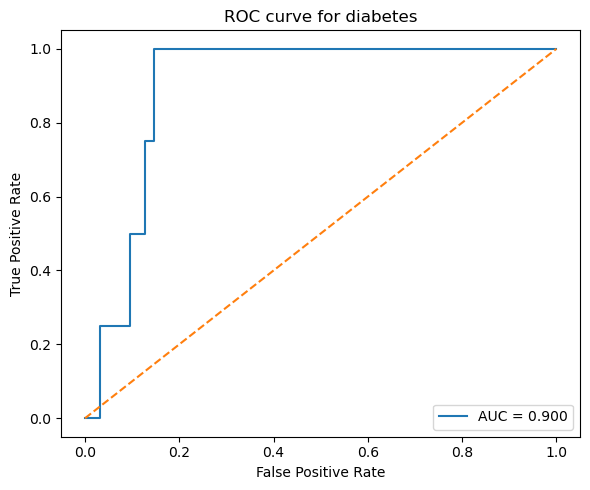

In [14]:
"""
Minimal demo script for disease risk prediction using ukbFound.

This script:
1) loads a small synthetic tokenised UKB-like dataset,
2) loads a lightweight pretrained demo model,
3) predicts risk for a single disease (TARGET_MEANING),
4) evaluates ROC-AUC and shows prevalence by risk quartile.
"""
import re
import json
from pathlib import Path

import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

from ukbfound.tokenizer.trait_tokenizer import ValueVocab
from ukbfound.tokenizer import tokenize_and_pad_batch
from ukbfound.model import TransformerModel
import ukbfound

logger = ukbfound.logger

# =============================================================================
# 0. 定义项目根目录（兼容脚本和 notebook）
# =============================================================================
if "__file__" in globals():
    PROJECT_ROOT = Path(__file__).resolve().parent
else:
    PROJECT_ROOT = Path(".").resolve().parent

DATA_DIR = PROJECT_ROOT / "data"      # 示例数据目录：data/
MODEL_DIR = PROJECT_ROOT / "model"    # 示例模型目录：model/

# =============================================================================
# 1. 读取数据与字典
# =============================================================================
data_df = pd.read_csv(DATA_DIR / "demo_UKB_tokens.csv", index_col=0)
traits_df = pd.read_csv(
    DATA_DIR / "ukb_traits.csv",
    encoding="latin1",
    quotechar='"',
    low_memory=False,
)

# 选择要演示的疾病（可以改成别的）
TARGET_MEANING = "diabetes"

# =============================================================================
# 2. 加载模型与 vocab
# =============================================================================
model_config_file = MODEL_DIR / "demo_config.json"
model_file = MODEL_DIR / "demo_model.pt"
vocab_file = MODEL_DIR / "demo_vocab.json"

pad_token = "<pad>"
mask_token = "<mask>"
cls_token = "<cls>"

vocab = ValueVocab.from_file(vocab_file)
vocab.set_default_index(vocab[pad_token])

mask_value = vocab[mask_token]
pad_value = vocab[pad_token]
cls_value = vocab[cls_token]

# ---- value_id -> trait_id 映射 ----
trait_dict = {v: i for i, v in enumerate(traits_df["trait"].unique(), 1)}
value2trait_dict = {
    value_id: trait_dict[
        traits_df.loc[traits_df["token_id"] == value_id, "trait"].iat[0]
    ]
    for value_id in traits_df["token_id"]
}

value2trait_dict.update({vocab[cls_token]: 0})
max_trait_id = max(value2trait_dict.values()) + 1
value2trait_dict.update({mask_value: max_trait_id})
value2trait_dict.update({pad_value: max_trait_id + 1})

vectorized_replace = np.vectorize(value2trait_dict.get)

# ---- Dataset ----
class SeqDataset(Dataset):
    def __init__(self, data_dict):
        self.data = data_dict

    def __len__(self):
        return self.data["trait_ids"].shape[0]

    def __getitem__(self, idx):
        return {k: v[idx] for k, v in self.data.items()}


# ---- 读取模型配置 ----
with open(model_config_file, "r") as f:
    model_configs = json.load(f)

logger.info(
    f"Resume model from {model_file}, the model args will override the "
    f"config {model_config_file}."
)

embsize = model_configs["layer_size"]
nhead = model_configs["nhead"]
d_hid = model_configs["layer_size"]
nlayers = model_configs["nlayers"]
dropout = model_configs["dropout"]
ecs_threshold = model_configs.get("ecs_thres", 0.0)

DAB = False
INPUT_BATCH_LABELS = False
num_batch_types = 1
DSBN = False
input_emb_style = "combine"
n_input_bins = None
individual_emb_style = "avg-pool"
mvc_decoder_style = "inner product"
explicit_zero_prob = True
fast_transformer = True   # 没装 flash-attn 时自动回退到 PyTorch 实现
fast_transformer_backend = "flash"
pre_norm = False
CLS = False
num_types = 1

ntokens = len(set(value2trait_dict.values()))

# =============================================================================
# 2.5 构建模型（严格按 TransformerModel 签名）
# =============================================================================
model = TransformerModel(
    ntoken=ntokens,
    d_model=embsize,
    nhead=nhead,
    d_hid=d_hid,
    nlayers=nlayers,
    nlayers_cls=3,
    n_cls=num_types if CLS else 1,
    vocab=vocab,
    dropout=dropout,
    pad_token=pad_token,
    do_dab=DAB,
    use_batch_labels=INPUT_BATCH_LABELS,
    num_batch_labels=num_batch_types,
    domain_spec_batchnorm=DSBN,
    input_emb_style=input_emb_style,
    n_input_bins=n_input_bins,
    individual_emb_style=individual_emb_style,
    mvc_decoder_style=mvc_decoder_style,
    ecs_threshold=ecs_threshold,
    explicit_zero_prob=explicit_zero_prob,
    use_fast_transformer=fast_transformer,
    fast_transformer_backend=fast_transformer_backend,
    pre_norm=pre_norm,
)

# ---- 加载模型参数 ----
state_dict = torch.load(model_file, map_location="cpu")
new_state_dict = {}
for key, value in state_dict.items():
    new_key = key[len("module.") :] if key.startswith("module.") else key
    new_state_dict[new_key] = value

model.load_state_dict(new_state_dict)
model.eval()
logger.info(f"Loading all model params from {model_file}")

# =============================================================================
# 3. 构建示例数据
# =============================================================================
np.random.seed(42)

keep_categories = ["Diet and alcohol summary", "Lifestyle"]
keep_traits_df = traits_df[
    (traits_df["category_name"].isin(keep_categories))
    | (traits_df["field_id"].isin([20002, 20001]))
]

test_df = data_df.copy()
test_df = test_df.fillna(pad_value)

keep_col_idx = [
    c
    for c in test_df.columns
    if int(re.search(r"d(\d+)-", c).group(1)) in keep_traits_df["field_id"].values
]
test_df = test_df.loc[:, keep_col_idx]

# =============================================================================
# 4. 选疾病、构造标签与输入
# =============================================================================
sel_traits_df = traits_df[
    (traits_df["meaning"] == TARGET_MEANING)
    & (traits_df["field_id"].isin([20002, 20001]))
]
if sel_traits_df.empty:
    raise ValueError(f"Cannot find disease meaning = {TARGET_MEANING}")

disease_tokens = sel_traits_df["token_id"].values
yes_token = disease_tokens[disease_tokens % 2 == 0][0]
no_token = disease_tokens[disease_tokens % 2 == 1][0]

print(f"Demo disease: {TARGET_MEANING}")
print(f"YES token id = {yes_token}, NO token id = {no_token}")

values_matrix = test_df.values
has_yes = np.any(values_matrix == yes_token, axis=1)
targets_binary = has_yes.astype(int)

trait_ids = vectorized_replace(values_matrix)

values_masked = values_matrix.copy()
values_masked[np.isin(values_masked, disease_tokens)] = mask_value

# =============================================================================
# 5. Tokenize + DataLoader
# =============================================================================
max_seq_len = 1500  # demo 用，足够且显存安全

tokenized = tokenize_and_pad_batch(
    values_masked,
    trait_ids,
    max_len=max_seq_len,
    vocab=vocab,
    pad_token=pad_token,
    pad_value=pad_value,
    append_cls=False,
    include_zero_value=True,
)

# 设备选择：优先用 GPU1
if torch.cuda.is_available():
    if torch.cuda.device_count() > 1:
        device = torch.device("cuda:1")
    else:
        device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

print("Using device:", device)

input_trait_ids = tokenized["traits"].to(device)
input_values = tokenized["values"].to(device)

dataset = SeqDataset(
    {
        "trait_ids": input_trait_ids,
        "values": input_values,
        "target_values": torch.tensor(values_matrix, device=device),
    }
)

loader = DataLoader(
    dataset,
    batch_size=8,      # 小一点，避免 OOM
    shuffle=False,
    drop_last=False,
    num_workers=0,
    pin_memory=False,
)

model.to(device)
torch.cuda.empty_cache()

# =============================================================================
# 6. 前向推理（按“每个个体”汇总概率）
# =============================================================================
all_probs = []

for batch in loader:
    batch = {k: v.to(device) for k, v in batch.items()}

    with torch.no_grad():
        pad_mask = batch["trait_ids"].eq(vocab[pad_token])
        hidden = model._encode(
            batch["trait_ids"],
            batch["values"],
            pad_mask,
            batch_labels=None,
        )
        # probs: (batch, seq_len, vocab_size)
        logits = model.combine_decoder(hidden)
        probs = F.softmax(logits, dim=-1)

        # 原始（未 mask 前）的 token 序列，用来确定哪些位置是该疾病的 YES/NO token
        target_vals = batch["target_values"].detach().cpu().numpy()
        probs_np = probs.detach().cpu().numpy()

        bsz = target_vals.shape[0]
        for i in range(bsz):
            # 这一行哪些位置属于该疾病（包括 YES / NO）
            disease_pos_i = np.isin(target_vals[i], disease_tokens)

            if disease_pos_i.any():
                # 在这些位置上，取模型对 yes_token 的预测概率
                # probs_np[i]: (seq_len, vocab_size)
                p_i_all = probs_np[i, disease_pos_i, yes_token]  # (num_pos_i,)
                prob_i = float(p_i_all.mean())
            else:
                # 理论上很少发生：个体没有这个疾病字段
                # 这里退而求其次，取全序列对 yes_token 概率的平均
                p_i_all = probs_np[i, :, yes_token]
                prob_i = float(p_i_all.mean())

            all_probs.append(prob_i)

all_probs = np.array(all_probs)
if all_probs.shape[0] != targets_binary.shape[0]:
    raise RuntimeError(
        f"prob length ({all_probs.shape[0]}) != target length ({targets_binary.shape[0]})"
    )

# =============================================================================
# 7. AUC & 分层
# =============================================================================
auc = roc_auc_score(targets_binary, all_probs)
print(f"ROC-AUC for {TARGET_MEANING}: {auc:.4f}")

q1, q2, q3 = np.percentile(all_probs, [25, 50, 75])


def assign_percentile(x):
    if x <= q1:
        return "Q1"
    elif x <= q2:
        return "Q2"
    elif x <= q3:
        return "Q3"
    else:
        return "Q4"


results_df = pd.DataFrame(
    {
        "eid": data_df.index,
        "prob": all_probs,
        "label": targets_binary,
    }
)
results_df["percentile"] = results_df["prob"].apply(assign_percentile)

summary = (
    results_df.groupby("percentile")["label"]
    .agg(["sum", "count"])
    .rename(columns={"sum": "positives", "count": "total"})
)
summary["prevalence"] = summary["positives"] / summary["total"]
print("\nPrevalence by risk quartile:")
print(summary)

safe_name = re.sub(r"[^\w]", "", TARGET_MEANING)
results_df.to_csv(f"demo_results_{safe_name}.csv", index=False)

fpr, tpr, _ = roc_curve(targets_binary, all_probs)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC curve for {TARGET_MEANING}")
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig(f"demo_ROC_{safe_name}.svg", dpi=300)
print(f"Saved demo ROC to demo_ROC_{safe_name}.svg")
